# Quick analysis of no-stress runs

Perturbation (using zero_surface_stress_exceptBL option in ocean_sbc):
/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_nostress

Control run:
/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_nostress_cont

Both initialized from WOA13.

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
client = Client(n_workers=8)

In [3]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_nostress.db'
session = cc.database.create_session(db)
exps = ['025deg_jra55_ryf_nostress_cont','025deg_jra55_ryf_nostress']
names = {'025deg_jra55_ryf_nostress_cont':'Control','025deg_jra55_ryf_nostress':'No Stress'}

distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

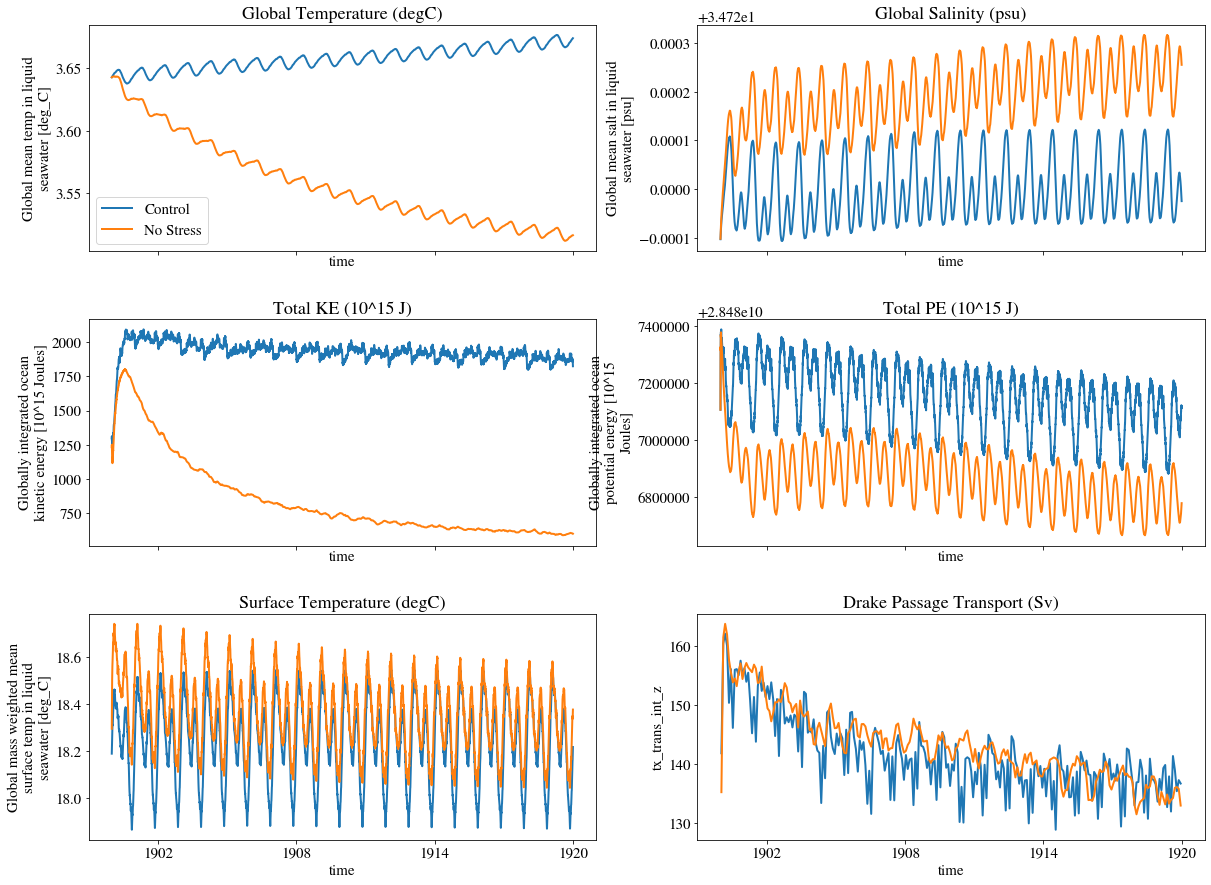

In [25]:
# Scalar time-series:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,15),facecolor='w',sharex=True)

# Calc DP transport:
xmin, xmax, ymin, ymax = -69.9, -69.9, -71.6, -51.0
rho0=1035.0

for exp in exps:
    cc.querying.getvar(exp,'temp_global_ave',session).plot(ax=axes[0][0],label=names[exp])#.resample(time='A').mean(dim='time')
    cc.querying.getvar(exp,'ke_tot',session).plot(ax=axes[1][0])
    cc.querying.getvar(exp,'salt_global_ave',session).plot(ax=axes[0][1])
    cc.querying.getvar(exp,'pe_tot',session).plot(ax=axes[1][1])
    cc.querying.getvar(exp,'temp_surface_ave',session).plot(ax=axes[2][0])

    DPtrans = cc.querying.getvar(exp,'tx_trans_int_z',session).sel(xu_ocean=xmin, method='nearest')\
                            .sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DPtrans.plot(ax=axes[2][1])

axes[0][0].set_title('Global Temperature (degC)')
axes[0][0].legend()
axes[1][0].set_title('Total KE (10^15 J)')
axes[0][1].set_title('Global Salinity (psu)')
axes[1][1].set_title('Total PE (10^15 J)')
axes[2][0].set_title('Surface Temperature (degC)')
axes[2][1].set_title('Drake Passage Transport (Sv)')
plt.subplots_adjust(hspace=0.3)

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


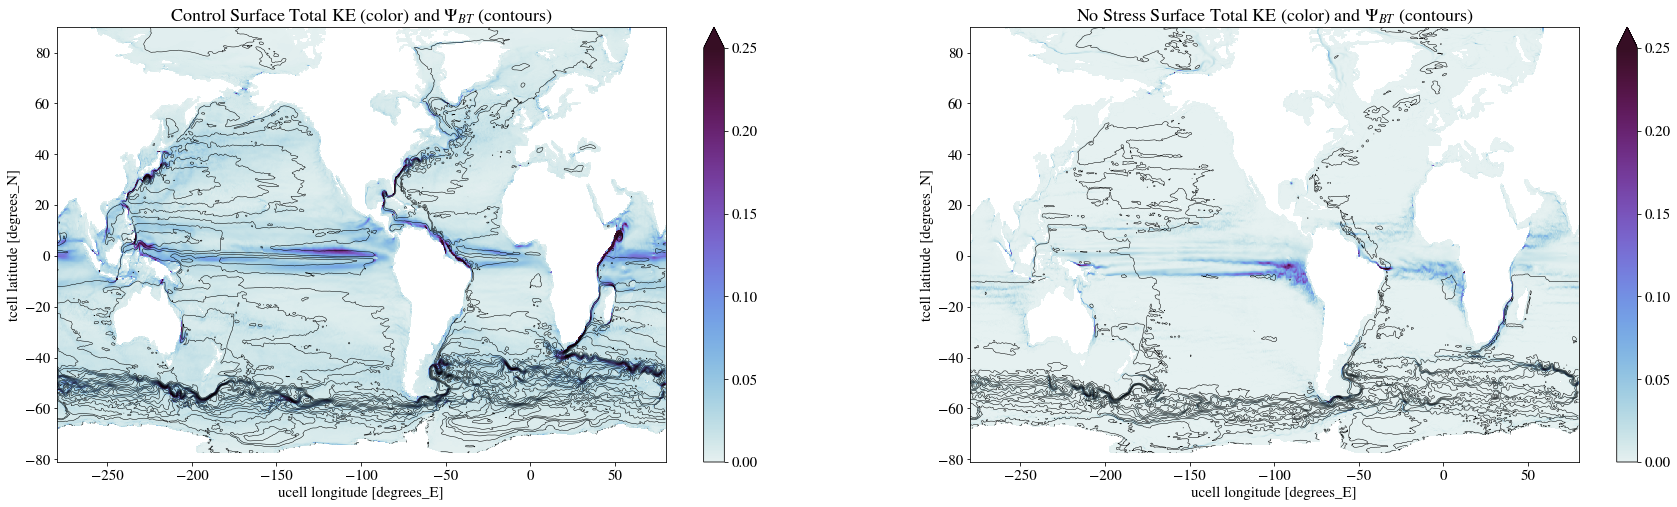

In [5]:
# Barotropic Streamfunction and surface velocities:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(30,8),facecolor='w')
lvls = np.arange(-250, 250, 10)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams.update({'font.size': 15})

rho0 =1035.
for i,exp in enumerate(exps):
    tx_trans_int_z = cc.querying.getvar(exp, 'tx_trans_int_z', session,n=-1).mean('time')
    psi = -tx_trans_int_z.cumsum('yt_ocean').where(abs(tx_trans_int_z<=1.e20))/(rho0*1.e6)
    speed = 0.5*(cc.querying.getvar(exp,'u',session,n=-1,ncfile = '%monthly-pow02%')+
                 cc.querying.getvar(exp,'v',session,n=-1,ncfile = '%monthly-pow02%'))
    speed.isel(st_ocean=0).mean('time').plot(ax=axes[i],vmin=0.,vmax=0.25,cmap=cm.cm.dense)
    psi.plot.contour(ax=axes[i],levels=lvls,colors='k',linestyles='-',linewidths=0.5)
    axes[i].set_title(names[exp] + ' Surface Total KE (color) and $\Psi_{BT}$ (contours)')

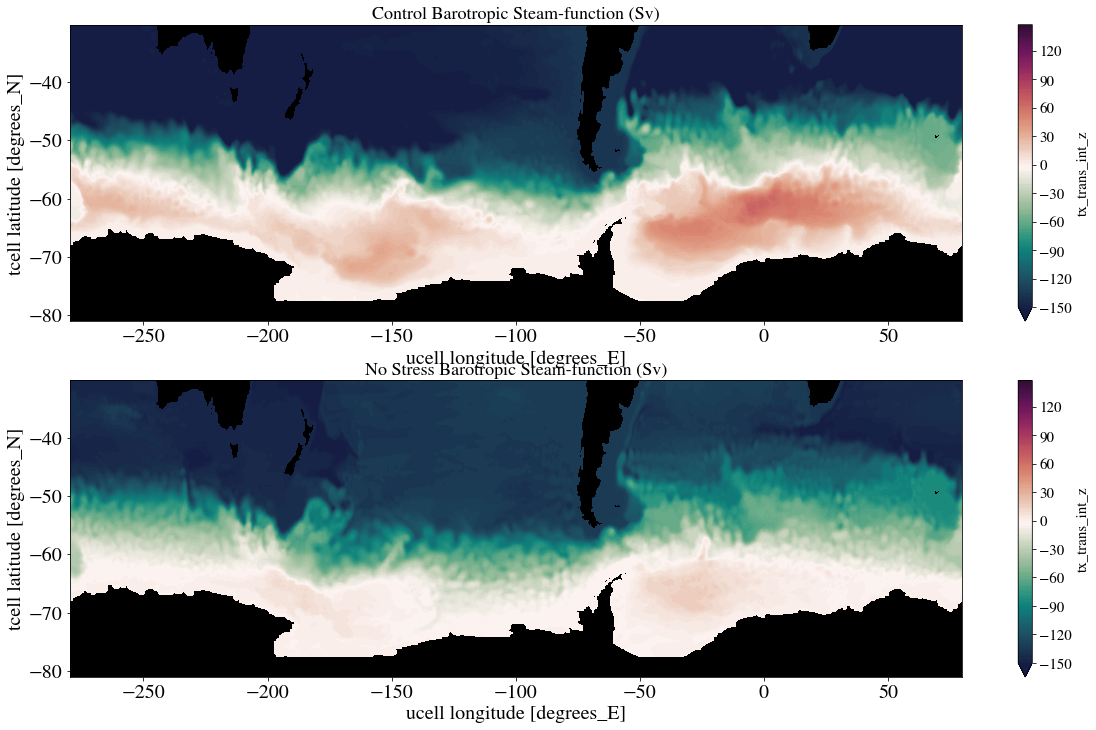

In [18]:
# Barotropic Streamfunction Southern Ocean:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(20,12),facecolor='w')
lvls = np.arange(-150, 150, 2.5)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams.update({'font.size': 15})

rho0 =1035.

for i,exp in enumerate(exps):
    tx_trans_int_z = cc.querying.getvar(exp, 'tx_trans_int_z', session,n=-1).mean('time').sel(yt_ocean=slice(-90.,-30.))
    psi = -tx_trans_int_z.cumsum('yt_ocean').where(abs(tx_trans_int_z<=1.e20))/(rho0*1.e6)
    psi.plot.contourf(ax=axes[i],levels=lvls,linestyles='-',linewidths=0.5,cmap=cm.cm.curl)
    axes[i].set_title(names[exp] + ' Barotropic Steam-function (Sv)')

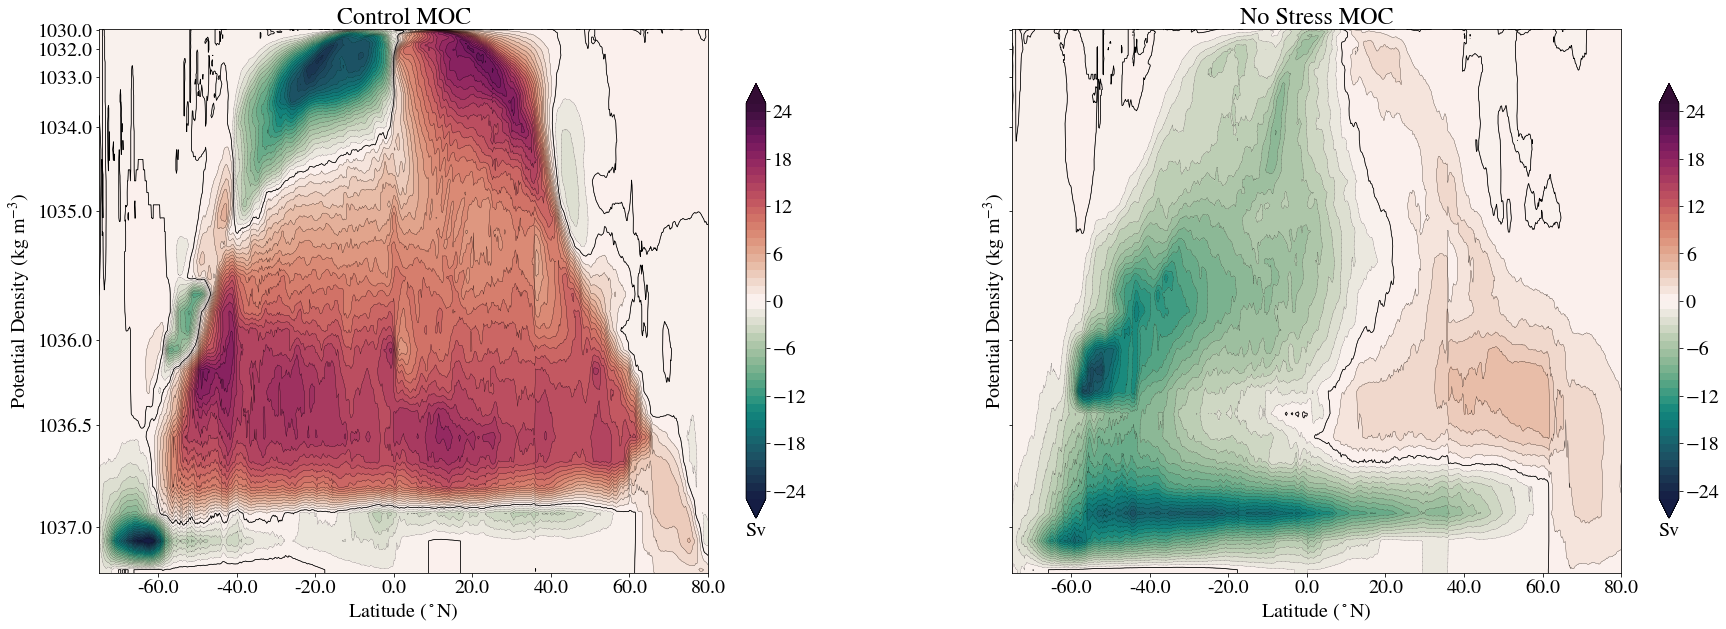

In [9]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 20})

# mask = np.copy(mask_atl_ut+mask_so_ut+mask_indpac_ut)
# tstr = 'Global'
# mask = xr.where(mask==0,np.nan,1.)

clev = np.arange(-25.,26.,1.)
rho0 = 1035.0
yticks = np.array([1030,1032,1033,1034,1035,1036,1036.5,1037])
scfac = 4

fig,axes = plt.subplots(nrows=1,ncols=2,facecolor='w',figsize=(30,10),sharex=True,sharey=True)

for i,exp in enumerate(exps):
    psi = cc.querying.getvar(exp, 'ty_trans_rho', session,n=-1).mean('time').sum('grid_xt_ocean').cumsum('potrho') + cc.querying.getvar(exp, 'ty_trans_rho_gm', session,n=-1).mean('time').sum('grid_xt_ocean')
    psi = psi/rho0/1.e6
    p1 = axes[i].contourf(psi.grid_yu_ocean,(psi.potrho-1028)**scfac,psi,cmap=cm.cm.curl,levels=clev,extend='both')
    axes[i].contour(psi.grid_yu_ocean,(psi.potrho-1028)**scfac,psi,levels=clev,colors='k', linewidths=0.25)
    axes[i].contour(psi.grid_yu_ocean,(psi.potrho-1028)**scfac,psi,levels=[0.,],colors='k', linewidths=0.75)  
    axes[i].set_yticks((yticks-1028)**scfac)
    axes[i].set_yticklabels(yticks)
    axes[i].set_ylim([0.5**scfac, 9.2**scfac])
    axes[i].invert_yaxis()
    axes[i].set_ylabel('Potential Density (kg m$^{-3}$)')
    axes[i].set_xlabel('Latitude ($^\circ$N)')
    axes[i].set_xlim([-75,80])
    axes[i].set_xticks(np.arange(-60.,100.,20.))
    axes[i].set_xticklabels(np.arange(-60.,100.,20.))
    cb = plt.colorbar(p1,ax = axes[i],shrink=0.8)
    cb.ax.set_xlabel('Sv')
    axes[i].set_title(names[exp] + ' MOC')

distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


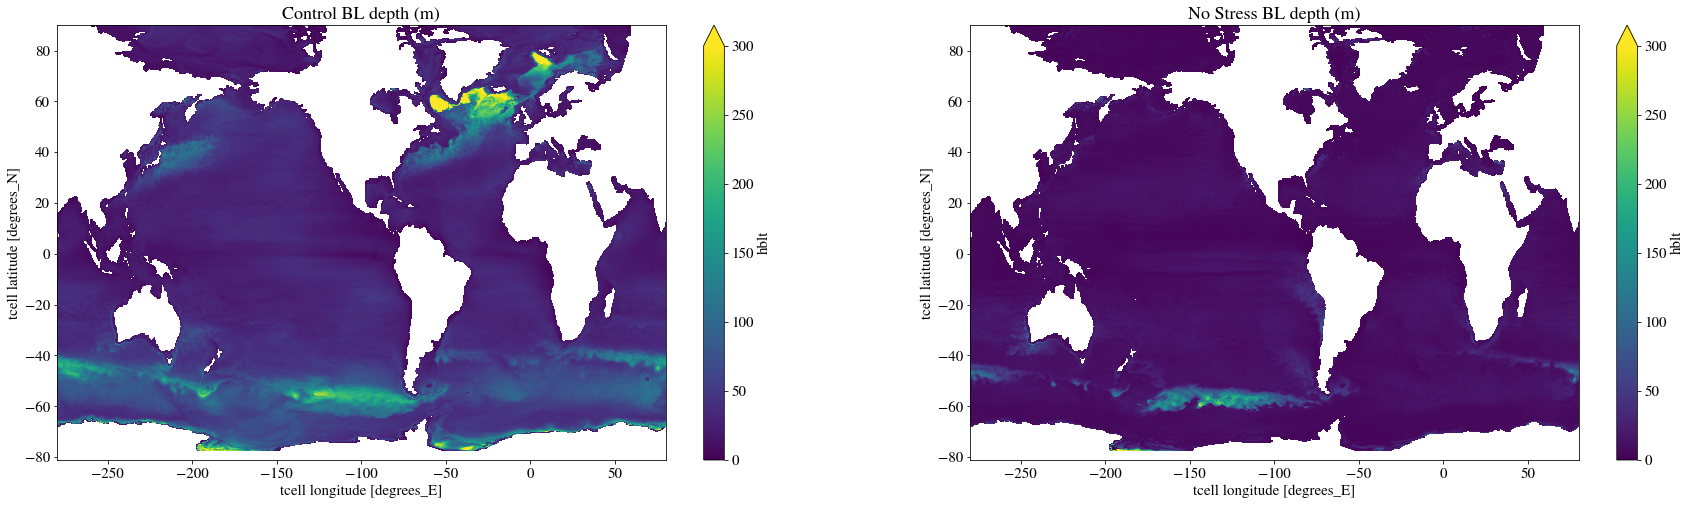

In [26]:
# BL depth
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(30,8),facecolor='w')
lvls = np.arange(-250, 250, 10)
plt.rcParams['axes.facecolor'] = 'black'

rho0 =1035.
# Grid (used for plotting)
# geolon_c = cc.querying.getvar(exp,'geolon_c', session)
# geolat_t = cc.querying.getvar(exp,'geolat_t', session)

for i,exp in enumerate(exps):
    hblt = cc.querying.getvar(exp, 'hblt', session,n=-1).mean('time').plot(ax=axes[i],vmin=0.,vmax=300.)
    axes[i].set_title(names[exp] + ' BL depth (m)')

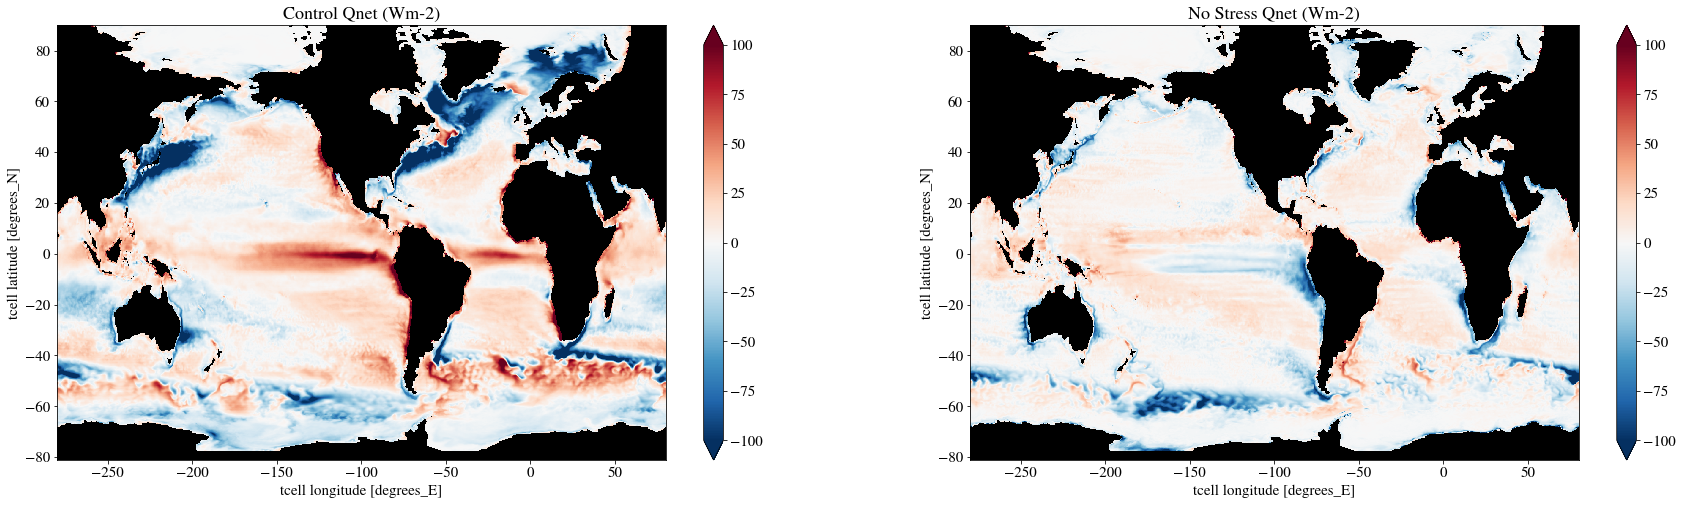

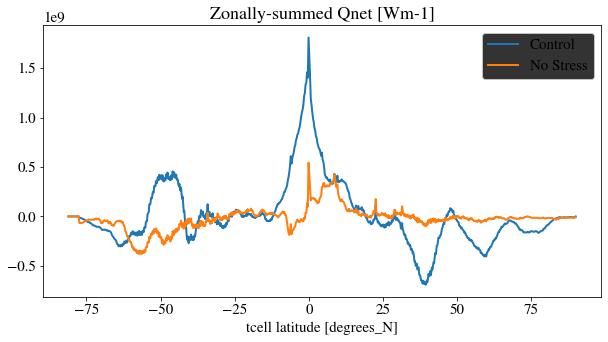

In [54]:
# Surface heat flux
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(30,8),facecolor='w')
plt.rcParams['axes.facecolor'] = 'black'
fig2, axes2 = plt.subplots(nrows=1,ncols=1,figsize=(10,5),facecolor='w')
lvls = np.arange(-250, 250, 10)


rho0 =1035.
# Grid (used for plotting)
# geolon_c = cc.querying.getvar(exp,'geolon_c', session)
# geolat_t = cc.querying.getvar(exp,'geolat_t', session)

for i,exp in enumerate(exps):
    Qnet = (cc.querying.getvar(exp, 'net_sfc_heating', session,n=-1)+cc.querying.getvar(exp, 'frazil_3d_int_z', session,n=-1)).mean('time')
    Qnet.plot(ax=axes[i],vmin=-100.,vmax=100.,cmap='RdBu_r')
    axes[i].set_title(names[exp] + ' Qnet (Wm-2)')
    Qnet_prof = (Qnet*cc.querying.getvar(exp,'area_t',session,n=-1)/cc.querying.getvar(exp,'dyt',session,n=-1).rename({'nj':'yt_ocean','ni':'xt_ocean'})).sum('xt_ocean')
    Qnet_prof.plot(ax=axes2,label=names[exp])

axes2.legend()
axes2.set_title('Zonally-summed Qnet [Wm-1]')
axes2.set_facecolor('w')
    
#fig2, axes2 = plt.subplots(nrows=1,ncols=1,figsize=(10,5),facecolor='w')
